In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

In [4]:
from sklearn.metrics import roc_auc_score
def best_ntree_score(estimator, X, y):
    """
    This scorer uses the best_ntree_limit to return
    the best AUC ROC score
    """
    try:
        y_predict = estimator.predict_proba(X,
                                            ntree_limit=estimator.best_ntree_limit)
    except AttributeError:
        y_predict = estimator.predict_proba(X)
    return roc_auc_score(y, y_predict[:, 1])

### Gradient boost guided example

Having walked through gradient boost by hand, now let's try it with SKlearn.  We'll still use the European Social Survey Data, but now with a categorical outcome: Whether or not someone lives with a partner.

In [2]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

Since we're now working with a binary outcome, we've switched to a classifier.  Now our loss function can't be the residuals.  Our options are "deviance", or "exponential".  Deviance is used for logistic regression, and we'll try that here.

In [5]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

print('train auc score',best_ntree_score(clf,X_train,y_train))
print('test auc score',best_ntree_score(clf,X_test,y_test))

Training set accuracy:
Percent Type I errors: 0.04650845608292417
Percent Type II errors: 0.17607746863066012

Test set accuracy:
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.18527607361963191
train auc score 0.8293659870648592
test auc score 0.7957074417119131


Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface.  But they aren't quite a black box.  We can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

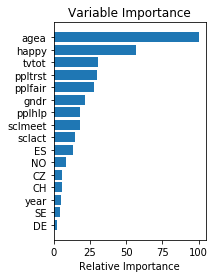

In [6]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

It appears that age and happiness are the most important features in predicting whether or not someone lives with a partner.

### DRILL: Improve this gradient boost model

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement.  Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set.  Strategies you might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

Have fun!

# parameter tuning using gridsearch 

In [7]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno','gndr'])]

df['gndr']=np.where(df['gndr']==1,'m','f')

# Make the categorical variable 'gndr' and 'country' into dummies.
X = pd.concat([X,pd.get_dummies(df['gndr'])], axis=1)
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

In [8]:
from sklearn.model_selection import GridSearchCV

# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {
    "loss":['exponential', 'deviance'],
    "learning_rate": [0.01,0.1,0.5],
    "min_samples_split": np.linspace(0.1, 0.5, 5),
    "min_samples_leaf": [50,100,150],
    "max_depth":[2],
    "subsample":[0.5, 0.8, 0.9],
    "n_estimators":[500,1000]
    }




# Initialize and fit the model.
clf = GridSearchCV(ensemble.GradientBoostingClassifier(), params, cv=10,scoring='roc_auc', n_jobs=-1)
clf.fit(X, y)

# predict_train = clf.predict(X_train)
# predict_test = clf.predict(X_test)

# Accuracy tables.
# table_train = pd.crosstab(y_train, predict_train, margins=True)
# table_test = pd.crosstab(y_test, predict_test, margins=True)

# train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
# train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

# test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
# test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

# print((
#     'Training set accuracy:\n'
#     'Percent Type I errors: {}\n'
#     'Percent Type II errors: {}\n\n'
#     'Test set accuracy:\n'
#     'Percent Type I errors: {}\n'
#     'Percent Type II errors: {}'
# ).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

# print('train auc score',best_ntree_score(clf,X_train,y_train))
# print('test auc score',best_ntree_score(clf,X_test,y_test))
# print(clf.best_params_)

GridSearchCV(cv=10, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'loss': ['exponential', 'deviance'], 'learning_rate': [0.01, 0.1, 0.5], 'min_samples_split': array([0.1, 0.2, 0.3, 0.4, 0.5]), 'min_samples_leaf': [50, 100, 150], 'max_depth': [2], 'subsample': [0.5, 0.8, 0.9], 'n_estimators': [500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [9]:
clf.grid_scores_, clf.best_params_, clf.best_score_

/Users/yunjin/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.78385, std: 0.02081, params: {'learning_rate': 0.01, 'loss': 'exponential', 'max_depth': 2, 'min_samples_leaf': 50, 'min_samples_split': 0.1, 'n_estimators': 500, 'subsample': 0.5},
  mean: 0.78343, std: 0.02116, params: {'learning_rate': 0.01, 'loss': 'exponential', 'max_depth': 2, 'min_samples_leaf': 50, 'min_samples_split': 0.1, 'n_estimators': 500, 'subsample': 0.8},
  mean: 0.78255, std: 0.02108, params: {'learning_rate': 0.01, 'loss': 'exponential', 'max_depth': 2, 'min_samples_leaf': 50, 'min_samples_split': 0.1, 'n_estimators': 500, 'subsample': 0.9},
  mean: 0.78926, std: 0.02026, params: {'learning_rate': 0.01, 'loss': 'exponential', 'max_depth': 2, 'min_samples_leaf': 50, 'min_samples_split': 0.1, 'n_estimators': 1000, 'subsample': 0.5},
  mean: 0.78809, std: 0.01973, params: {'learning_rate': 0.01, 'loss': 'exponential', 'max_depth': 2, 'min_samples_leaf': 50, 'min_samples_split': 0.1, 'n_estimators': 1000, 'subsample': 0.8},
  mean: 0.78774, std: 0.01982, params:

I test with parameters as follows: <br>
    "loss":['exponential', 'deviance'],<br>
    "learning_rate": [0.01,0.1,0.5],<br>
    "min_samples_split": np.linspace(0.1, 0.5, 5),<br>
    "min_samples_leaf": [50,100,150],<br>
    "max_depth":[2],<br>
    "subsample":[0.5, 0.8, 0.9],<br>
    "n_estimators":[500,1000]<br>
 
 Best parameters which resulted in the highest roc auc score was <br>
  {'learning_rate': 0.1, <br>
  'loss': 'exponential',<br>
  'max_depth': 2,<br>
  'min_samples_leaf': 150,<br>
  'min_samples_split': 0.1,<br>
  'n_estimators': 500,<br>
  'subsample': 0.9},<br>
 
 Best roc auc score was 0.7949970162953596. However, this score is lower than that of example above. 
 The parameters used in above example might be the best hyperparameters for this gradient boosting classifier model.